Nicolas Brandstetter
Felipe Keim

Predicción de inicio y final de un evento de huso del sueño

In [221]:
#Imports
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time

# loading data

In [222]:
test_marks = torch.tensor(np.load('data_sigma_spindles/test_marks.npy'))
test_signals = torch.tensor(np.load('data_sigma_spindles/test_signals.npy'))
train_marks = torch.tensor(np.load('data_sigma_spindles/train_marks.npy'))
train_signals = torch.tensor(np.load('data_sigma_spindles/train_signals.npy'))
val_marks = torch.tensor(np.load('data_sigma_spindles/val_marks.npy'))
val_signals = torch.tensor(np.load('data_sigma_spindles/val_signals.npy'))
print(test_signals)

tensor([[ 26.3256,  27.9165,  27.8290,  ...,  20.5286,  21.0742,  20.7298],
        [ -8.2109,  -9.4852,  -9.3056,  ...,  -9.6107,  -9.9441,  -9.9490],
        [ -3.4718,  -2.2240,  -1.4831,  ...,   9.8945,   9.5982,   8.1645],
        ...,
        [  9.1788,   6.6849,   5.8792,  ...,   7.1602,   3.9604,   0.8572],
        [ -3.4990,  -0.5417,   3.5563,  ...,  -4.2979,  -1.4342,   0.8087],
        [  9.3037,  10.5672,   9.6996,  ..., -16.1384, -13.0277,  -9.0365]])


## Creating Dataset

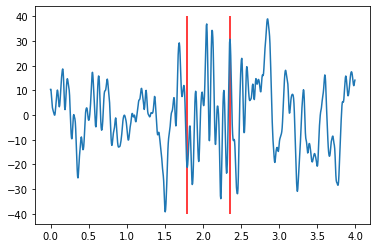

In [223]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)
a=np.load('data_sigma_spindles/train_signals.npy')
b=np.load('data_sigma_spindles/train_marks.npy')
t=np.arange(len(a[0]))*(4/800)
plt.plot(t,a[0])
plt.vlines(b[0]*(4/800),-40,40,colors="r")


# Model Definition

In [224]:
class CNN_Model(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        nfilter1=1
        nfilter2=2
        n_out_network=1
        self.conv_blocks = nn.Sequential(

            # nn.ConvTranspose2d(1,1,kernel_size=1,stride=1)  
            nn.Conv1d(in_channels=1,out_channels=nfilter1,kernel_size=1,padding="same"),
            nn.ReLU(),
            nn.Conv1d(in_channels=nfilter1,out_channels=nfilter2,kernel_size=1,padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            nn.Flatten(),

            nn.Linear(in_features=400,out_features=n_out_network)
        )


    def forward(self, x):
        return self.conv_blocks(x)

# Función de entrenamiento y visualización

## Curvas

In [225]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()

def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss



## Training set up

In [226]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

In [227]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # if data_augmentation:
    #     train_dataset.dataset.transform = torchvision.transforms.Compose([
    #         original_transform,
    #         torchvision.transforms.RandomHorizontalFlip(),
    #         torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
    #     ])

    # else:
    #     train_dataset.dataset.transform = original_transform
    # train_dataset.dataset.transform = original_transform

    # print(f"Using train transform: {train_dataset.dataset.transform}")
    # print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0


        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

In [228]:
a=np.array([1,2,3])
b=np.array([4,5,6])
c=np.arange(len(a))
for x,y,i in zip(a,b,c):
    print(x)
    print(y)
    print(i)

1
4
0
2
5
1
3
6
2


# Training

In [229]:
lr = 5e-4
batch_size = 1
criterion = nn.CrossEntropyLoss()
epochs = 2

CNN1 = CNN_Model(dropout_p=0.5)
print(CNN1(train_ds[0][0].unsqueeze(0)).shape)
print(CNN1(train_ds[0][0].unsqueeze(0)))


torch.Size([2, 1])
tensor([[-0.0683],
        [ 0.1259]], grad_fn=<AddmmBackward0>)


In [230]:
curves = train_model(
    CNN1,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
)
show_curves(curves)

Epoch 1/2


ValueError: Expected input batch_size (2) to match target batch_size (1).